## Импорт

In [ ]:
import os
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
import pandas as pd
import json


## Подготовка данных

In [1]:
# Пути к данным
raw_data_dir = '../data/raw/'
output_path = '../data/processed/context_answer.csv'
character = 'House'

# Функция для очистки текста
def clean_text(text):
    text = re.sub(r'\[.*?\]|\(.*?\)', '', text)  # Удаление текста в скобках 
    text = re.sub(r'\s+', ' ', text)  # Удаление лишних пробелов
    text = text.strip()  # Удаление пробелов в начале и конце
    # text = text.lower()  # Приведение к нижнему регистру (опционально)
    # text = text.translate(str.maketrans('', '', string.punctuation))  # Удаление пунктуации (опционально)
    return text

# Загрузка всех CSV-файлов из директории
all_files = [os.path.join(raw_data_dir, f) for f in os.listdir(raw_data_dir) if f.endswith('.csv')]
df_list = []
for file in all_files:
    try:
        df = pd.read_csv(file, encoding='ISO-8859-1')
        df_list.append(df)
    except UnicodeDecodeError:
        df = pd.read_csv(file, encoding='utf-8')
        df_list.append(df)
full_text = pd.concat(df_list, ignore_index=True)

# Очистка данных
full_clean_text = full_text.dropna(subset=['name', 'line']).reset_index(drop=True)
full_clean_text.loc[:, 'line'] = full_clean_text['line'].apply(clean_text)

# Формирование пар "контекст-ответ"
min_length = 5  # Минимальная длина реплики
pairs = []
for i in range(1, len(full_clean_text)):
    if full_clean_text.loc[i, 'name'] == character:
        context = full_clean_text.loc[i - 1, 'line']
        response = full_clean_text.loc[i, 'line']
        if context and response and len(context.split()) >= min_length and len(response.split()) >= min_length:
            pairs.append({'context': context, 'response': response})
pairs_df = pd.DataFrame(pairs)


## Анализ и очистка данных

Основная информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12329 entries, 0 to 12328
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   12329 non-null  object
 1   response  12329 non-null  object
dtypes: object(2)
memory usage: 192.8+ KB
None

Пропуски в данных:
context     0
response    0
dtype: int64

Найденные аномальные символы: {'\x97', '/', '%', '¡', 'é', '@', '_', '#', '±', '[', '¢', '\x9f', '¶', '¯', '\x93', '§', 'º', '&', '³', '*', '¿', '{', ']', '$', 'Ã', '½', '\x9d', '\x89', '+', 'ï'}

Описательная статистика длин реплик:
       context_length  response_length
count    12329.000000     12329.000000
mean        13.333360        16.687728
std          9.888599        12.976904
min          5.000000         5.000000
25%          7.000000         8.000000
50%         10.000000        13.000000
75%         16.000000        21.000000
max        185.000000       175.000000


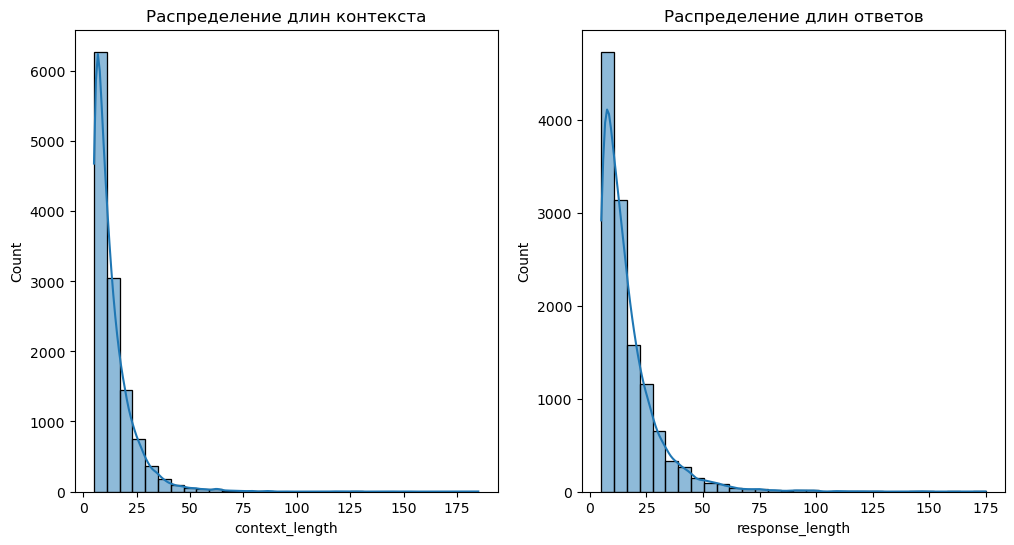


Топ-20 слов в контекстах: [('that', 1238), ('have', 1156), ('your', 1066), ('with', 960), ('just', 845), ("don't", 807), ('this', 695), ("It's", 623), ('about', 607), ("you're", 564), ('think', 546), ("it's", 533), ('know', 528), ('could', 515), ('what', 509), ('want', 477), ("You're", 466), ('like', 444), ('What', 431), ('going', 395)]
Топ-20 слов в ответах: [('that', 2078), ('your', 1557), ('have', 1309), ('with', 1135), ('just', 840), ("don't", 836), ('this', 788), ("you're", 756), ("It's", 705), ('what', 696), ("it's", 691), ('about', 659), ('know', 594), ('like', 549), ('want', 506), ('think', 501), ('What', 481), ('would', 478), ('need', 456), ("You're", 449)]

Уникальных контекстов: 12277
Уникальных ответов: 12312

Количество дубликатов пар 'контекст-ответ': 0

Случайные примеры пар 'контекст-ответ':
                                                 context  \
524    Hi boys. Mrs. Campbell's test results. Oh, you...   
4686   Worried about meeting your one Patient a week ...   


In [2]:
# Основная информация
print("Основная информация о данных:")
print(pairs_df.info())

# Проверка на пропуски
print("\nПропуски в данных:")
print(pairs_df.isnull().sum())

# Добавим столбцы с длиной реплик
pairs_df['context_length'] = pairs_df['context'].apply(lambda x: len(x.split()))
pairs_df['response_length'] = pairs_df['response'].apply(lambda x: len(x.split()))

# Поиск и удаление аномалий
allowed_chars = r"[a-zA-Z0-9\s.,!?;:'\"()\-]"  # Определим допустимые символы с помощью регулярного выражения
anomalous_chars = set()

def find_anomalous_characters(text):
    anomalous_chars = set()
    for char in text:
        if not re.match(allowed_chars, char):
            anomalous_chars.add(char)
    return anomalous_chars

for text in pairs_df['context']:
    anomalous_chars.update(find_anomalous_characters(text))
for text in pairs_df['response']:
    anomalous_chars.update(find_anomalous_characters(text))

print("\nНайденные аномальные символы:", anomalous_chars)

# Функция для удаления запрещенных символов
def remove_anomalous_characters(text):
    # Используем регулярное выражение для поиска всех допустимых символов
    cleaned_text = re.findall(allowed_chars, text)
    # Соединяем найденные символы обратно в строку
    return ''.join(cleaned_text)

# Применим функцию ко всем репликам в DataFrame
pairs_df['context'] = pairs_df['context'].apply(remove_anomalous_characters)
pairs_df['response'] = pairs_df['response'].apply(remove_anomalous_characters)


# Описательная статистика
print("\nОписательная статистика длин реплик:")
print(pairs_df[['context_length', 'response_length']].describe())

# Визуализация распределения длин реплик
plt.figure(figsize=(12, 6))

# Распределение длин контекста
plt.subplot(1, 2, 1)
sns.histplot(pairs_df['context_length'], bins=30, kde=True)
plt.title('Распределение длин контекста')

# Распределение длин ответов
plt.subplot(1, 2, 2)
sns.histplot(pairs_df['response_length'], bins=30, kde=True)
plt.title('Распределение длин ответов')

plt.show()

# Топ-20 слов в контекстах и ответах
def get_top_words(column, top_n=20):
    all_words = ' '.join(column).split()
    filtered_words = [word for word in all_words if word.lower() if len(word) > 3]
    word_counts = Counter(filtered_words)
    return word_counts.most_common(top_n)

top_context_words = get_top_words(pairs_df['context'])
print("\nТоп-20 слов в контекстах:", top_context_words)

top_response_words = get_top_words(pairs_df['response'])
print("Топ-20 слов в ответах:", top_response_words)

# Уникальные реплики
unique_contexts = pairs_df['context'].nunique()
unique_responses = pairs_df['response'].nunique()

print(f"\nУникальных контекстов: {unique_contexts}")
print(f"Уникальных ответов: {unique_responses}")

# Поиск дубликатов
duplicates = pairs_df.duplicated(subset=['context', 'response']).sum()
print(f"\nКоличество дубликатов пар 'контекст-ответ': {duplicates}")

# Случайные примеры
print("\nСлучайные примеры пар 'контекст-ответ':")
print(pairs_df.sample(5))

# Сохранение данных
pairs_df.to_csv(output_path, index=False)


## Подготовка данных для GPT2

In [3]:
# Загрузка данных из CSV
data_path = '../data/processed/context_answer.csv'
df = pd.read_csv(data_path)

# Преобразование данных в JSON
data_json = []

for index, row in df.iterrows():
    # Создаем запись с полями character, q и a
    entry = {
        "character": "house",  # Укажите имя персонажа
        "q": row["context"],      # context -> q
        "a": row["response"]      # response -> a
    }
    data_json.append(entry)
    

## Подготовка данных для LLAMA

In [6]:
# Сохранение в JSON-файл
output_path = '../data/processed/context_answer.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(data_json, f, ensure_ascii=False, indent=4)

print(f"Данные сохранены в {output_path}")


Данные сохранены в ../data/processed/context_answer.json
